# 1) Load dependencies, set session parameters, and load the CIFAR-10 data

The main point of this CIFAR10 demonstration over the MNIST here is to demonstrate how classical models begin to fall short as the complexity of the data scales. Furthermore, CNNs really begin to shine here over MLP models for training efficiency, performance, and representation learning.

In [1]:
## Basic PyTorch functionality
import torch
from torch import nn
from torch.utils.data import DataLoader

## CPU data structures
import pandas as pd
import numpy as np

## Public datasets
import torchvision.datasets as datasets
import torchvision.transforms as transforms

## Classical ML-frameworks
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

## Plotting
import matplotlib.pyplot as plt

## Custom modules
import jm_pytorch_tutorials as jpt
from jm_pytorch_tutorials.models import MLP, CNN, SklearnModelWrapper

In [2]:
# Hyperparameters for session
batch_size = 64
device = jpt.utils.get_device()
print(f"Using device: {device}")

Using device: mps


In [3]:
# Dataset downloading, normalization, adding to train/test splits

download=False

# Transform for normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # mean, std for RGB
])

# A reverse transform for visualization later
unnormalize = transforms.Normalize(
    mean=[-1, -1, -1],
    std=[2, 2, 2]
)

# Download CIFAR-10 trainset
train_set = datasets.CIFAR10(
    root='./data', 
    train=True,
    download=download, 
    transform=transform)

train_loader = DataLoader(
    train_set, 
    batch_size=64,
    shuffle=True, 
    num_workers=2)

# Class names for later use
class_names = train_set.classes

# Download CIFAR-10 testset
test_set = datasets.CIFAR10(
    root='./data',
    train=False,            
    download=download,
    transform=transform
)

# Wrap in a DataLoader
test_loader = DataLoader(
    test_set,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

# 2) Training/Testing PyTorch and Sklearn models

In [4]:
## PyTorch Train/Test

# Instantiate Pytorch models
torch_models = {
    "MLP": MLP(input_shape=(3, 32, 32), hidden_dims=[512, 256], num_classes=10),
    "CNN": CNN(input_shape=(3, 32, 32), conv_channels=[32, 64], fc_dims=[256], num_classes=10),
}

# Loop through to train/test all Pytorch models
for name, model in torch_models.items():
    # Train each Pytorch model instance
    jpt.train.train_torch_model(model, train_loader, epochs=3,
                optimizer_class=torch.optim.Adam,
                learning_rate=0.001,
                criterion=nn.CrossEntropyLoss())
    # Evaluate each trained Pytorch model on a test dataset
    print(f"Testing {name}")
    jpt.test.evaluate_torch_model(model, test_loader, 
                                  class_names=None, save_to_model=True)

Training model: MLP
Trainable parameters: 1,707,274
Epoch 1/3: Loss = 1279.5924 | Time = 14.72s
Epoch 2/3: Loss = 1117.9526 | Time = 14.66s
Epoch 3/3: Loss = 1031.2268 | Time = 14.61s
Total training time: 43.99s
Testing MLP
Evaluating model: MLP

Evaluation Accuracy: 51.56% | Time: 12.32s
Per-Class ROC AUC and PR AUC:
  class_0: ROC AUC = 0.913, PR AUC = 0.621
  class_1: ROC AUC = 0.937, PR AUC = 0.705
  class_2: ROC AUC = 0.827, PR AUC = 0.391
  class_3: ROC AUC = 0.831, PR AUC = 0.331
  class_4: ROC AUC = 0.849, PR AUC = 0.434
  class_5: ROC AUC = 0.859, PR AUC = 0.433
  class_6: ROC AUC = 0.918, PR AUC = 0.594
  class_7: ROC AUC = 0.895, PR AUC = 0.640
  class_8: ROC AUC = 0.925, PR AUC = 0.675
  class_9: ROC AUC = 0.910, PR AUC = 0.634

Macro ROC AUC: 0.886 | Macro PR AUC: 0.546
Training model: CNN
Trainable parameters: 1,070,794
Epoch 1/3: Loss = 1038.0155 | Time = 15.23s
Epoch 2/3: Loss = 729.7377 | Time = 15.24s
Epoch 3/3: Loss = 594.2555 | Time = 15.23s
Total training time: 45.

In [5]:
## Sklearn Fit/Eval

# Flatten images and move to CPU
X_train = train_set.data.reshape((len(train_set.data), -1))  # shape: [50000, 3072]
y_train = np.array(train_set.targets)
X_test = test_set.data.reshape((len(test_set.data), -1))  # shape: [50000, 3072]
y_test = np.array(test_set.targets)

# Subsample to speed up training
X_train_small = X_train[:10000]
y_train_small = y_train[:10000]

# Instantiate wrapped Sklearn models
sklearn_models = {
    #"SVM": SklearnModelWrapper(SVC(kernel='linear', probability=True)),
    "RF": SklearnModelWrapper(RandomForestClassifier(n_estimators=100, n_jobs=-1)),
    "NB": SklearnModelWrapper(GaussianNB())
}

# Loop through Sklearn models to fit/eval
for name, model in sklearn_models.items():
    model.fit(X_train_small, y_train_small)
    metrics = model.evaluate(X_test, y_test)

Training RandomForestClassifier
Training time: 2.11s
Evaluating RandomForestClassifier
Evaluating model: RandomForestClassifier
Training GaussianNB
Training time: 0.11s
Evaluating GaussianNB
Evaluating model: GaussianNB


# 3) Organizing/visualizing eval metrics

In [6]:
## Consolidate models and evaluation metrics
all_models = {** sklearn_models, **torch_models}
results = []

for name, model in all_models.items():
    results.append(model.eval_metrics)

In [7]:
## Structure results into a DataFrame if you'd like
df = pd.DataFrame([{
    "Model": r["label"],
    "Accuracy": r["accuracy"],
    "AUROC": r["auroc"],
    "AUPRC": r["auprc"],
    "Train Time (s)": r["train_time"],
    "Inference Time (s)": r["inference_time"]
} for r in results])
print(df.round(4))

                    Model  Accuracy   AUROC   AUPRC  Train Time (s)  \
0  RandomForestClassifier    0.4195  0.8280  0.4139          2.1142   
1              GaussianNB    0.2930  0.7133  0.2255          0.1083   
2                     MLP   51.5600  0.8864  0.5457         43.9945   
3                     CNN   70.6500  0.9566  0.7830         45.6924   

   Inference Time (s)  
0              0.0462  
1              0.6292  
2             12.3221  
3             12.4656  


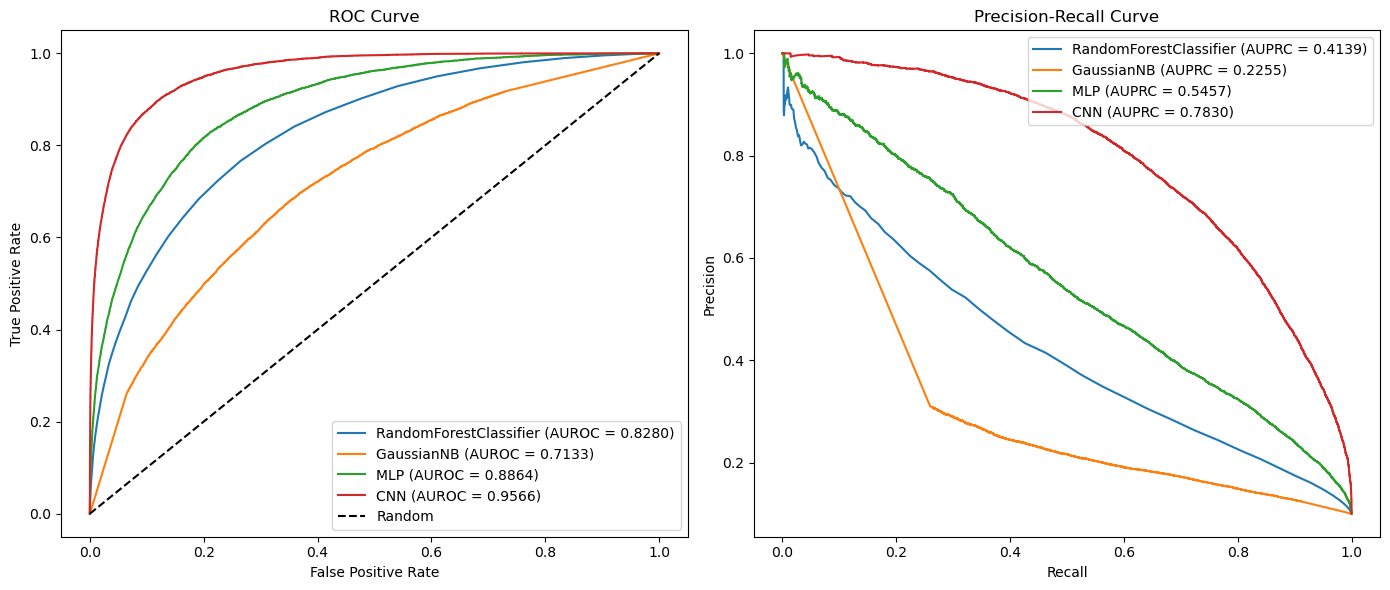

In [8]:
## Plot ROC and P/R curves
jpt.plot_roc_pr_curves(results)

# 4) Model interpretability

In [9]:
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Feature saliency for MLP


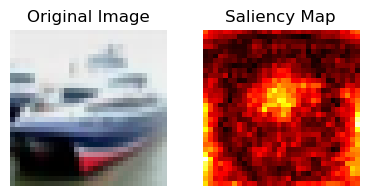

Feature saliency for CNN


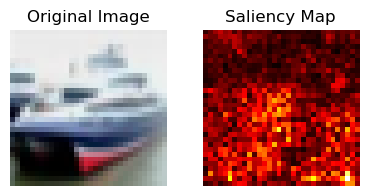

In [10]:
# Pick a test image
x, y = test_set[1]

# Unnormalize the input image
x_unnorm = unnormalize(x)

for name, model in torch_models.items():
    print(f"Feature saliency for {name}")
    sal = jpt.compute_saliency(model, x, y)
    jpt.show_saliency_map(x_unnorm, sal)

In [11]:
## Look at the structure of the CNN model class
cnn = torch_models['CNN']
cnn

CNN(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)

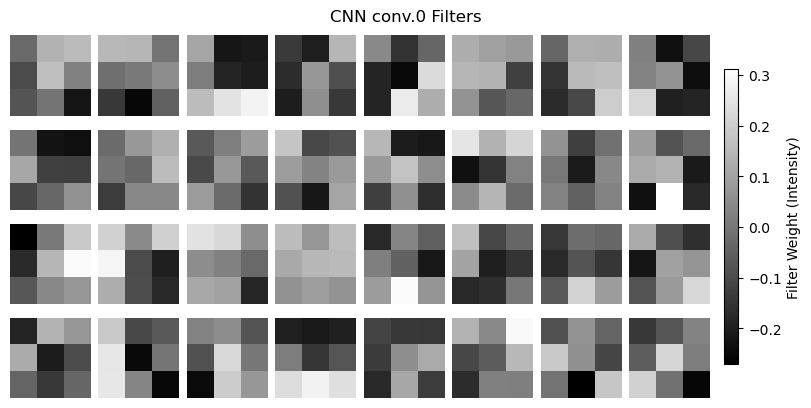

In [12]:
## Visualize the learned filters from the first convolutional layer of the CNN
layer_name = "conv.0"
layer = dict(cnn.named_modules()).get(layer_name, None)

weights = jpt.get_conv_filters(layer)
jpt.plot_conv_filters(weights, title=f"CNN {layer_name} Filters")

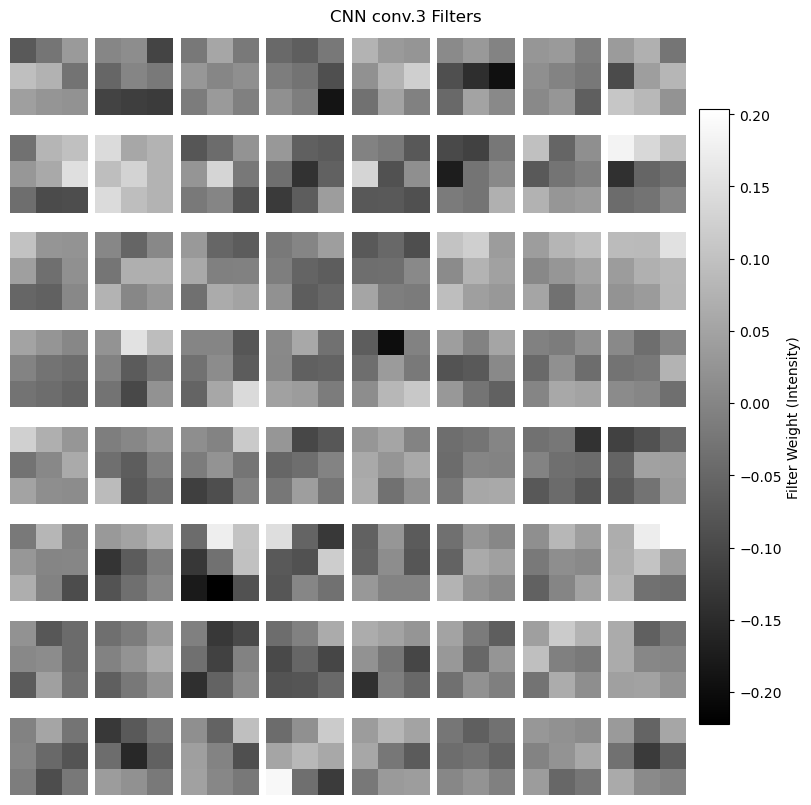

In [13]:
# Plot filters from second convolutional layer
layer_name = "conv.3"
layer = dict(cnn.named_modules()).get(layer_name, None)

weights = jpt.get_conv_filters(layer)
jpt.plot_conv_filters(weights, title=f"CNN {layer_name} Filters")

In [22]:
# Choose a test image to use for visualizing convolutions, activation patterns, and classification logits
img, label = test_set[0]
# Unnormalize the image back to raw values for plotting purposes
raw_img = unnormalize(img)

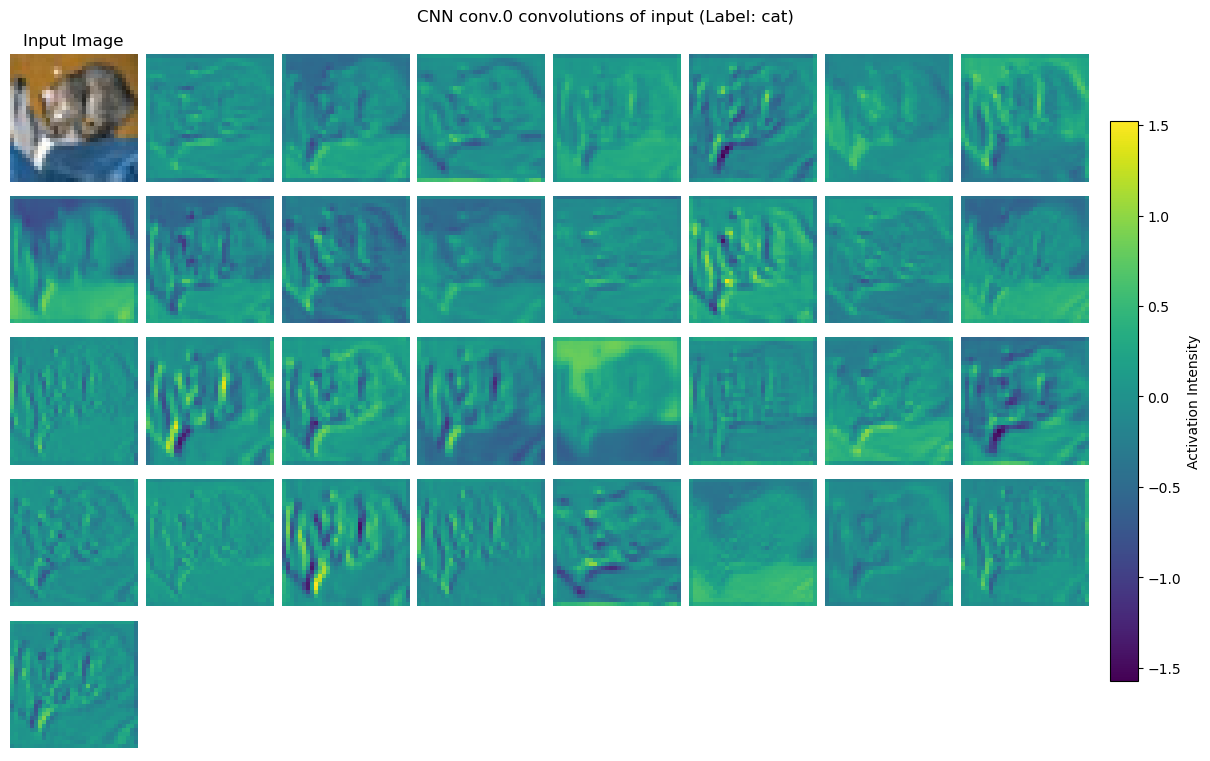

In [23]:
## Visualize the convolutions from the learned filters of the first convolutional layer
layer_name='conv.0'

# Get convolutions
feature_maps = jpt.get_feature_maps(cnn, img, layer_name=layer_name)

# Plot input + convolutions
jpt.plot_feature_maps(raw_img, feature_maps, title=f"{cnn.name} {layer_name} convolutions of input (Label: {class_names[label]})")

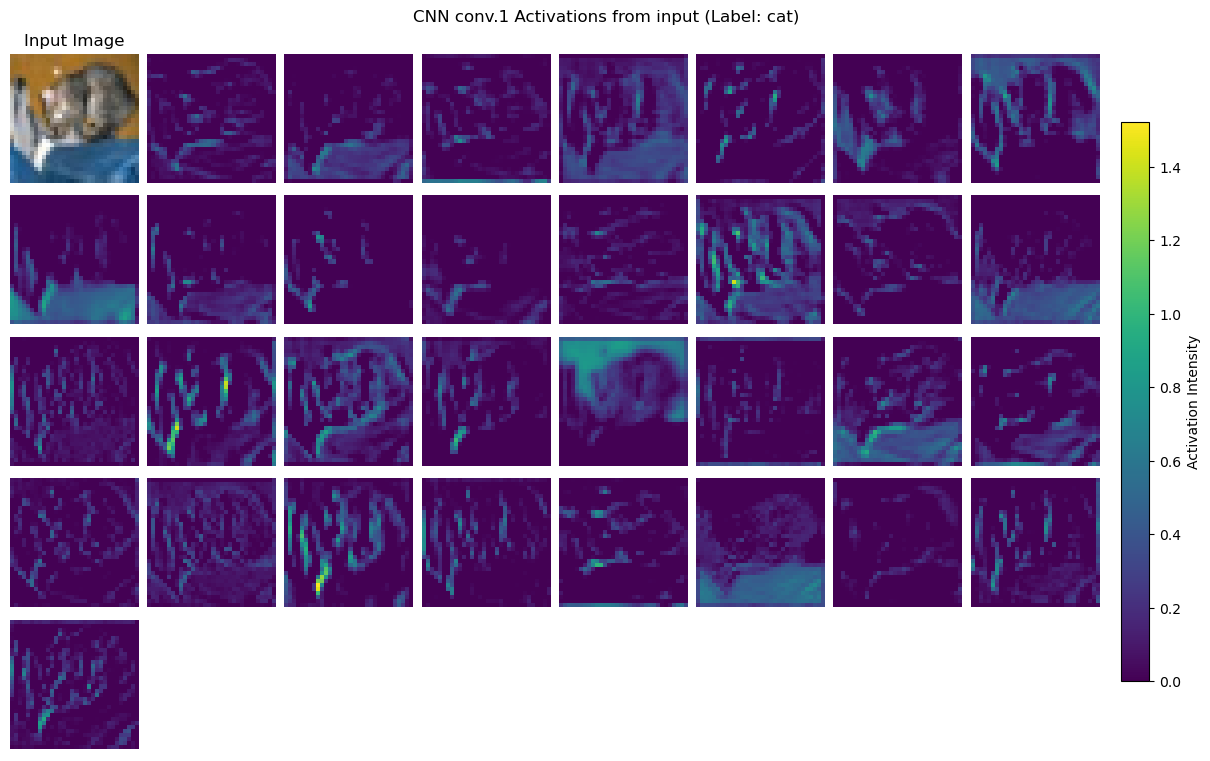

In [24]:
## Visualize the activation patterns from the convolutions

layer_name='conv.1'

# Get activations
feature_maps = jpt.get_feature_maps(cnn, img, layer_name=layer_name)

# Plot input + activations
jpt.plot_feature_maps(raw_img, feature_maps, title=f"{cnn.name} {layer_name} Activations from input (Label: {class_names[label]})")

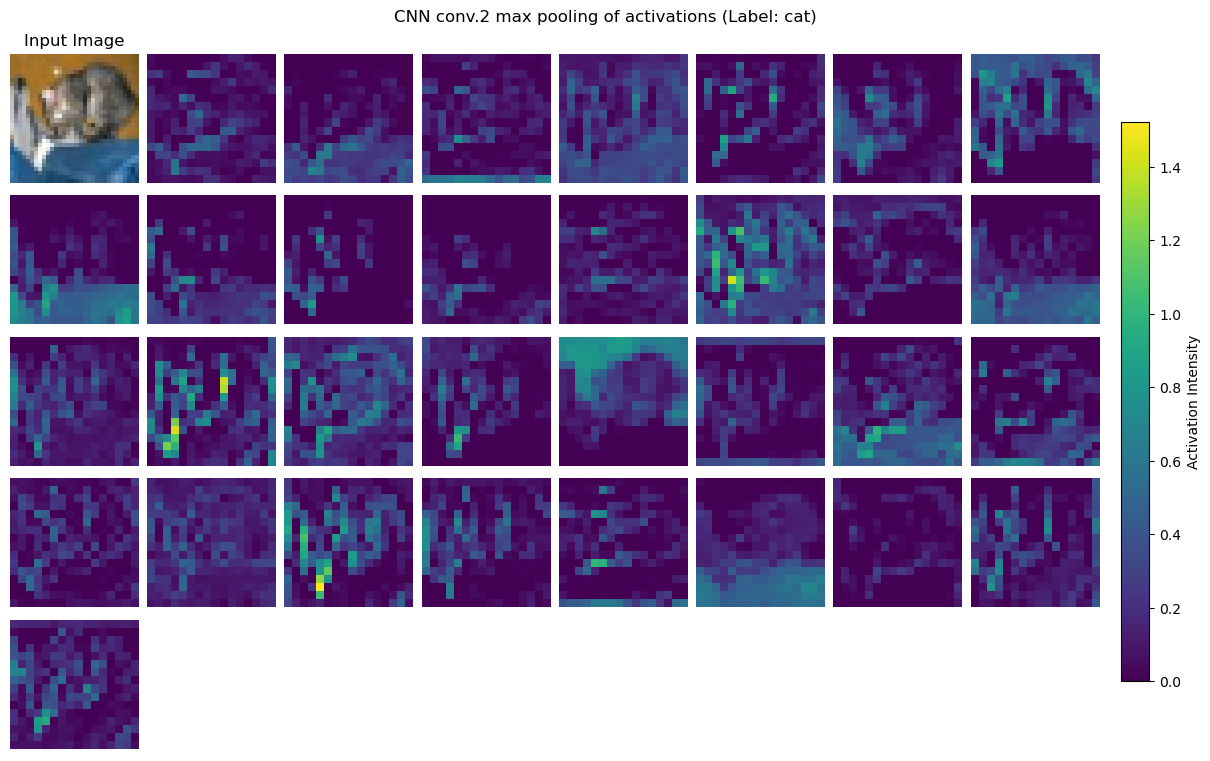

In [25]:
## Visualize the max pooling of activations

layer_name='conv.2'

# Get max pooled features
feature_maps = jpt.get_feature_maps(cnn, img, layer_name=layer_name)

# Plot input + max pooled downsampling
jpt.plot_feature_maps(raw_img, feature_maps, title=f"{cnn.name} {layer_name} max pooling of activations (Label: {class_names[label]})")

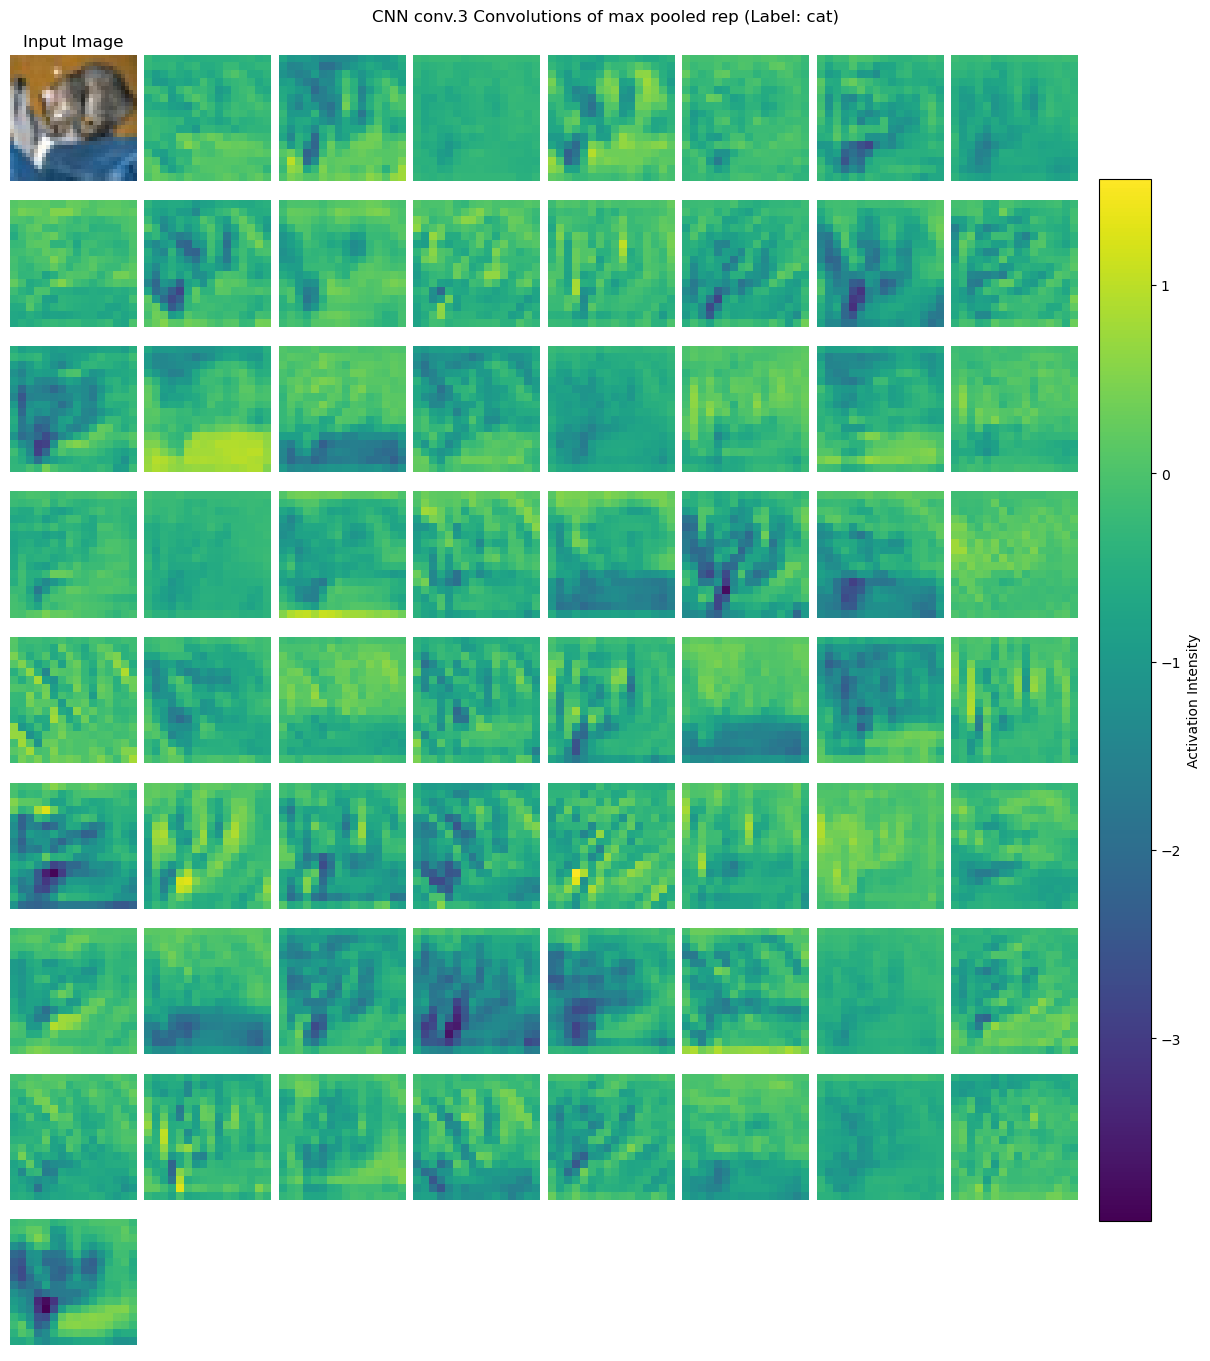

In [26]:
## Visualize the second convolution.

layer_name='conv.3'

# Get activations
feature_maps = jpt.get_feature_maps(cnn, img, layer_name=layer_name)

# Plot input + convolution
jpt.plot_feature_maps(raw_img, feature_maps, title=f"{cnn.name} {layer_name} Convolutions of max pooled rep (Label: {class_names[label]})")

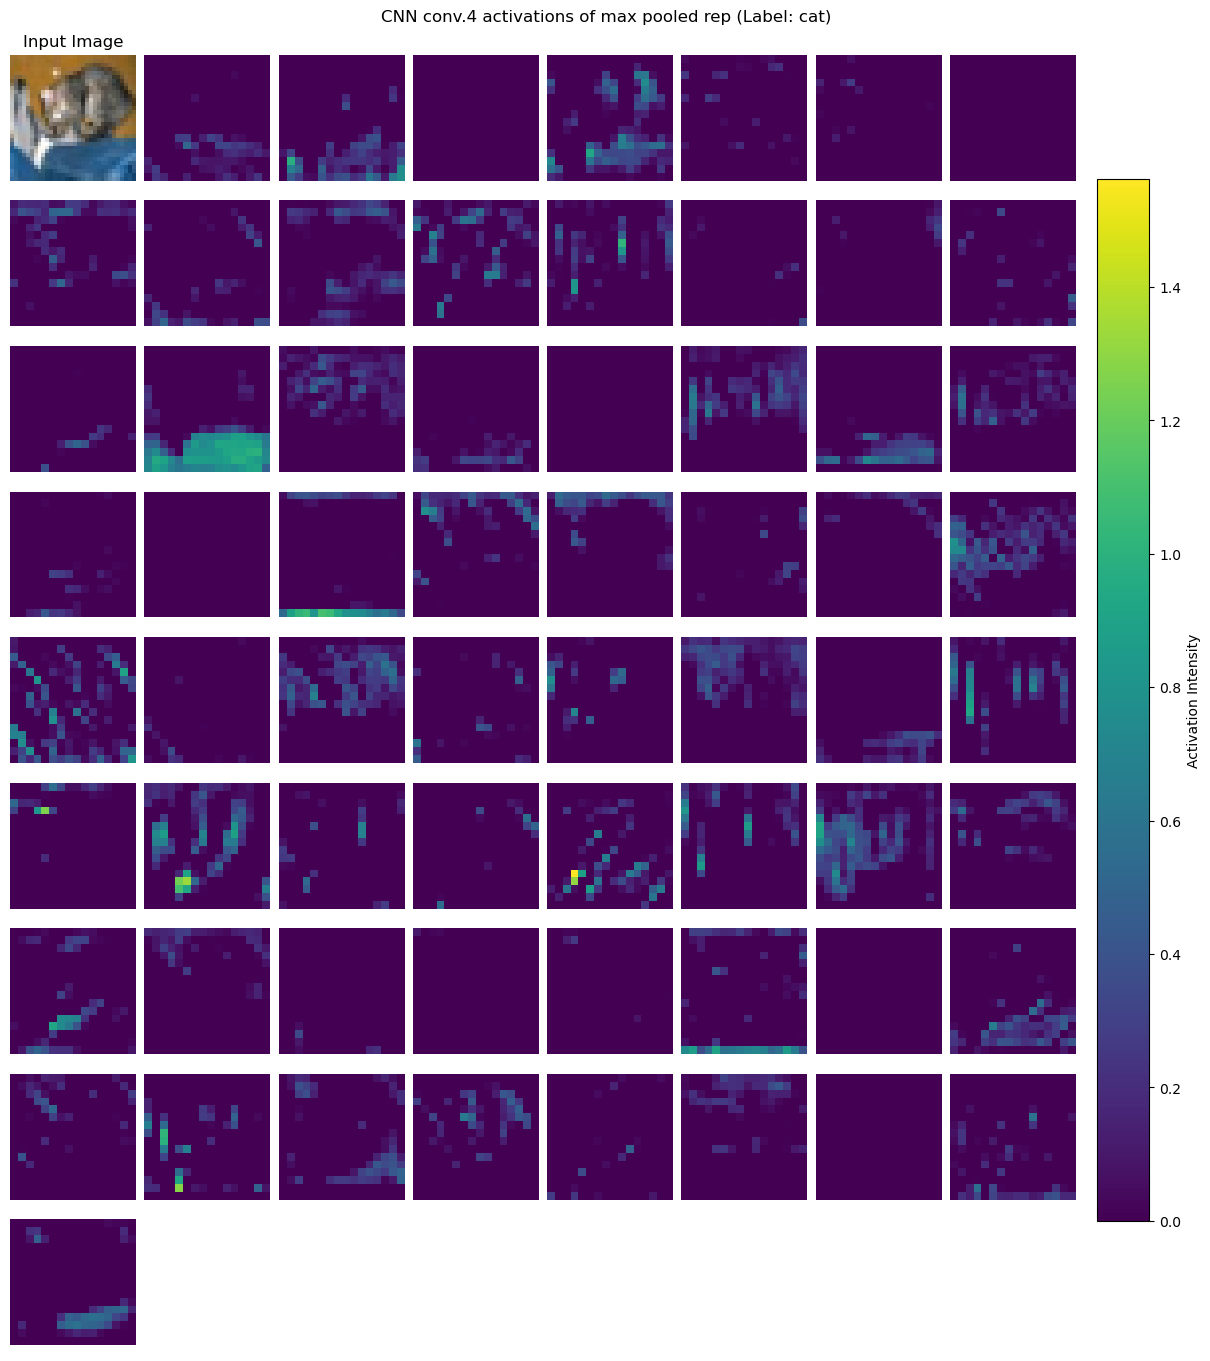

In [27]:
## Visualize the activation patterns from the second convolutional layer

layer_name='conv.4'

# Get convolutions
feature_maps = jpt.get_feature_maps(cnn, img, layer_name=layer_name)

# Plot input + activations
jpt.plot_feature_maps(raw_img, feature_maps, title=f"{cnn.name} {layer_name} activations of max pooled rep (Label: {class_names[label]})")

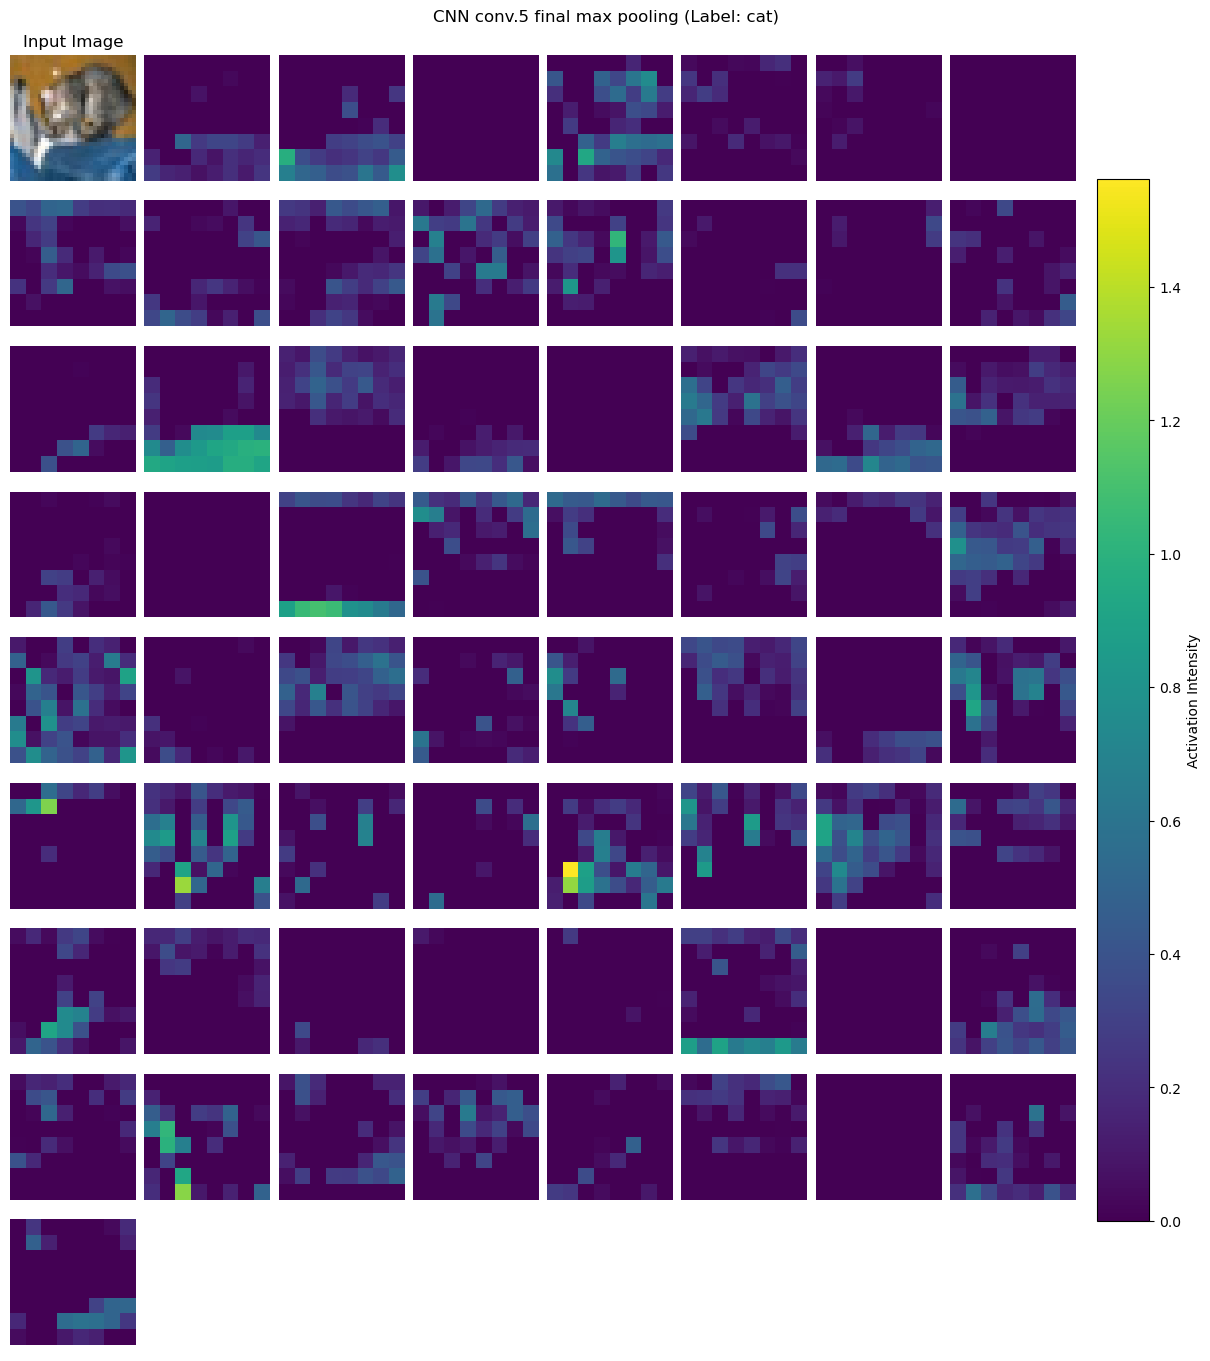

In [28]:
## Visualize the final max pooling

layer_name='conv.5'

# Get final max pooled faetures
feature_maps = jpt.get_feature_maps(cnn, img, layer_name=layer_name)

# Plot input + final max pooling of features
jpt.plot_feature_maps(raw_img, feature_maps, title=f"{cnn.name} {layer_name} final max pooling (Label: {class_names[label]})")

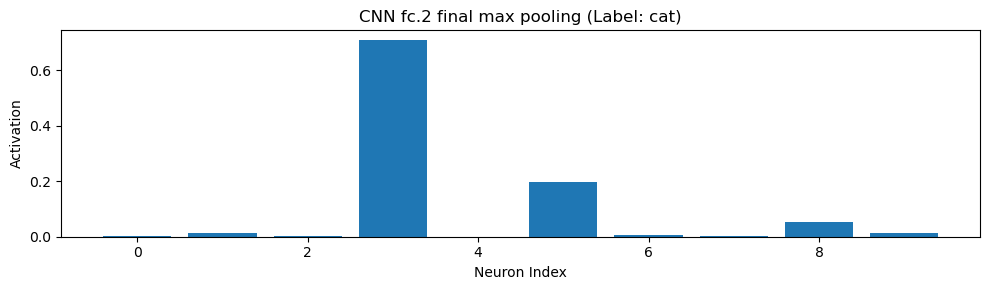

In [29]:
## Visualize the final class output

layer_name='fc.2'

# Get activations
feature_maps = jpt.get_feature_maps(cnn, img, layer_name=layer_name)

# Plot input + activations
jpt.plot_dense_activation(feature_maps, title=f"{cnn.name} {layer_name} final max pooling (Label: {class_names[label]})", softmax=True)

In [30]:
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']